# Задание

### Преподаватель: 
Олег Булыгин, Даниил Корбут, Наталья Баданина

### Цель:
Изучить применение моделей кластеризации

### Описание задания:
В домашнем задании нужно сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.
Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

### Этапы работы:
1. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).  
a) Для отображения картинки воспользуйтесь вспомогательной функцией:  
<code> import matplotlib.pyplot as plt
    import cv2
    import skimage
    def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis(‘off’)
    plt.imshow(new_image)
    plt.title(title)
    plt.show()  
</code>
b) Для загрузки картинки можно использовать код:  
<code> img = cv.imread(path)</code>

2. Реализуйте три модели кластеризации:  
a) KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20.  
b) DBSCAN  
c) AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20.  

3. Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.
4. Сформулируйте выводы по проделанной работе.  
a) Какая модель показала лучший результат?

### Для получения зачета 
по этому домашнему заданию минимально должно быть реализовано обучение трех моделей с одним и тем же значением кластеров, где такой параметр присутствует.

### Результат:
Получены знания по применению моделей кластеризации.

### Форма выполнения:
- ссылка на Jupyter Notebook, загруженный на GitHub;
- ссылка на Google Colab;
- файл с расширением .ipynb.

### Инструменты:
- Jupyter Notebook/Google Colab;
- GitHub;
- палитра изображения.

### Срок выполнения: дедлайн приема решений на проверку
*Рекомендации к выполнению:

- Текст оформляйте в отдельной ячейке Jupyter Notebook/Google Colab в формате markdown.
- У графиков должен быть заголовок, подписи осей, легенда (опционально). Делайте графики бОльшего размера, чем стандартный вывод, чтобы увеличить читабельность.
- Убедитесь, что по ссылкам есть доступ на чтение/просмотр.
- Убедитесь, что все ячейки в работе выполнены и можно увидеть их вывод без повторного запуска.

___
#### 1. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).
a) Для отображения картинки воспользуйтесь вспомогательной функцией  
b) Для загрузки картинки можно использовать код

In [ ]:
# Спасибо https://habr.com/ru/company/otus/blog/558426/ за помощь в первом знакомстве с OpenCV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
def draw_picture(image, title, bgr=False, raw=True):
    if raw:
        b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
        new_image = cv2.merge([r, g, b])
    else:
        new_image = image
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()  

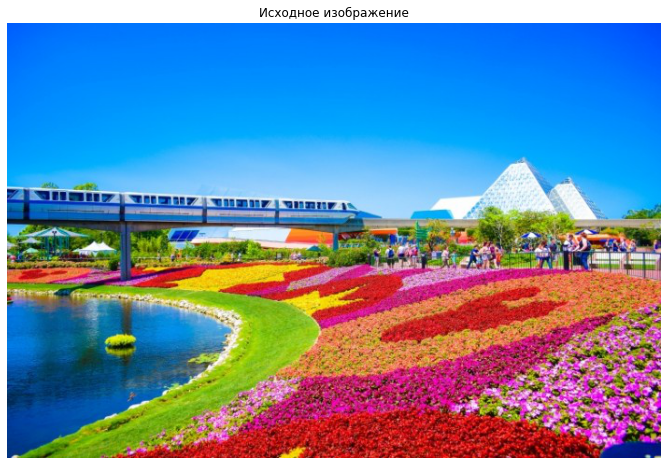

In [2]:
path = 'homework_13.jpg'
img = cv2.imread(path)
draw_picture(img, 'Исходное изображение')

In [4]:
# Подготовим датасет для анализа.
# Фактически для выполнения задачи нам не важно взаимоное расположение пикселей на картинке, 
# нам важны только параметры отдельно взятого пиксела. В этой связи представляется разумным сформировать датасет,
# в котором каждая строчка будет соответствовать отдельному пикселю, а колонки будут содержать информацию о цветовой гамме
# пикселя (r g b)

# получаем три массива, содержащих информацию о цветах пикселей картинки
b, g, r = cv2.split(img)
# формируем трехмерный массив по строкам и столбцам изображения с инфой о каждом пикселе 
img_matrix = cv2.merge([r, g, b])

# получаем информацию о размере изображения img_w - ширина в пикселях, img_h - высота в пикселях, img_pxls - кол-во цветовых каналов 
img_w, img_h, img_pxls = img_matrix.shape
print(img_w, img_h, img_pxls)
#print(img_matrix)

# формируем список пикселей изображения
img_pixels = img_matrix.reshape(img_w * img_h, 3)
print(img_pixels)

pixels_df = pd.DataFrame(img_pixels, columns=('red', 'green', 'blue'))
pixels_df.head()
img_pixels

466 700 3
[[  0  92 255]
 [  0  92 255]
 [  0  92 255]
 ...
 [205 213 172]
 [201 213 173]
 [195 210 171]]


array([[  0,  92, 255],
       [  0,  92, 255],
       [  0,  92, 255],
       ...,
       [205, 213, 172],
       [201, 213, 173],
       [195, 210, 171]], dtype=uint8)

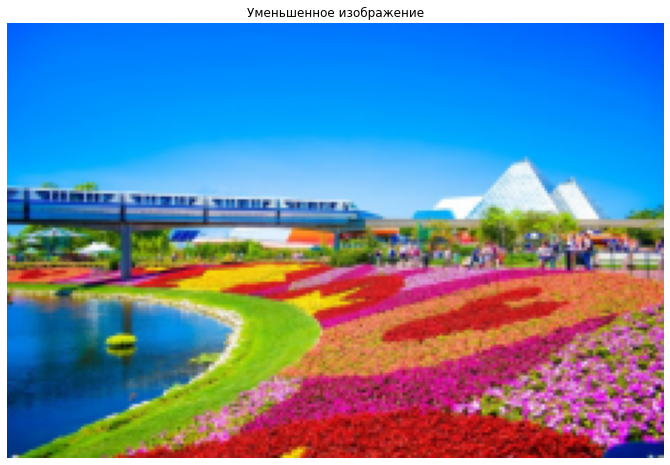

In [9]:
# Получаем копию изображения, уменьшенную в три раза по каждому из измерений
scale_percent = 33 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

draw_picture(img_resized, 'Уменьшенное изображение')

In [10]:
# получаем три массива, содержащих информацию о цветах пикселей картинки
b_r, g_r, r_r = cv2.split(img_resized)
# формируем трехмерный массив по строкам и столбцам изображения с инфой о каждом пикселе 
img_resized_matrix = cv2.merge([r_r, g_r, b_r])

# получаем информацию о размере изображения img_w - ширина в пикселях, img_h - высота в пикселях, img_pxls - кол-во цветовых каналов 
img_w_r, img_h_r, img_pxls_r = img_resized_matrix.shape
print(img_w_r, img_h_r, img_pxls_r)

# формируем список пикселей изображения
img_pixels_r = img_resized_matrix.reshape(img_w_r * img_h_r, 3)
print(img_pixels_r)

pixels_r_df = pd.DataFrame(img_pixels_r, columns=('red', 'green', 'blue'))
pixels_r_df.head()
img_pixels_r

153 231 3
[[  0  93 254]
 [  0  93 253]
 [  0  95 254]
 ...
 [ 37  58 119]
 [129 135 132]
 [133 143 140]]


array([[  0,  93, 254],
       [  0,  93, 253],
       [  0,  95, 254],
       ...,
       [ 37,  58, 119],
       [129, 135, 132],
       [133, 143, 140]], dtype=uint8)

### 2. Реализуйте три модели кластеризации:  
a) KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20.  
b) DBSCAN  
c) AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20.  

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
#from sklearn.metrics import adjusted_rand_score, silhouette_score

In [6]:
# Вначале - небольшая "пристрелка"
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(img_pixels)
#labels_kmeans_2 = kmeans_2.labels_
print(kmeans_2.labels_)
centroids_kmeans_2 = [[int(pxl[0]), int(pxl[1]), int(pxl[2])] for pxl in kmeans_2.cluster_centers_]
print(centroids_kmeans_2)

[1 1 1 ... 0 0 0]
[[164, 102, 73], [32, 145, 235]]


In [7]:
# А теперь попытаюсь упаковать в отдельную функцию все, что понадобится для отрисовки оптимизированной картинки
def modify_img(src_image_pixels, img_w, img_h, method):
    method.fit(src_image_pixels)
    labels = method.labels_
    centroids = [[int(pxl[0]), int(pxl[1]), int(pxl[2])] for pxl in method.cluster_centers_]
    new_image_pixels = [centroids[cluster] for cluster in labels]
    ret_img = np.array(new_image_pixels).reshape(img_w, img_h, 3)
    return ret_img


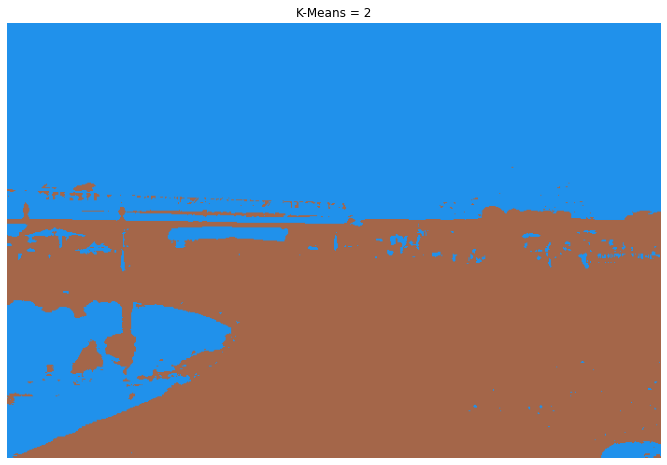

Wall time: 2.92 s


In [8]:
%%time
img_kmeans_2 = modify_img(img_pixels, img_w, img_h, KMeans(n_clusters=2, random_state=0))
draw_picture(img_kmeans_2, 'K-Means = 2', raw=False)

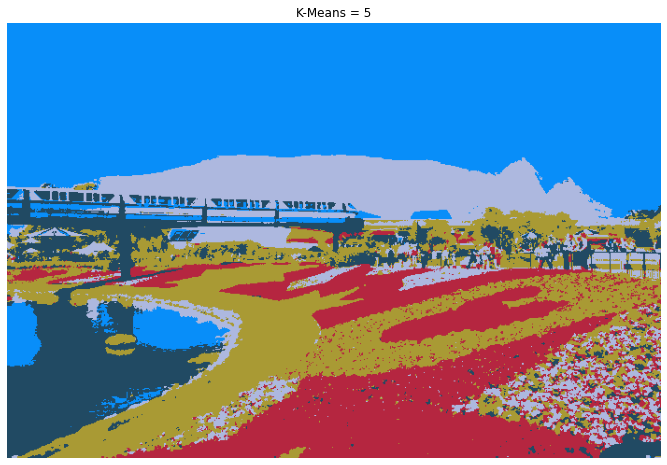

Wall time: 7.69 s


In [9]:
%%time
img_kmeans_5 = modify_img(img_pixels, img_w, img_h, KMeans(n_clusters=5, random_state=0))
draw_picture(img_kmeans_5, 'K-Means = 5', raw=False)

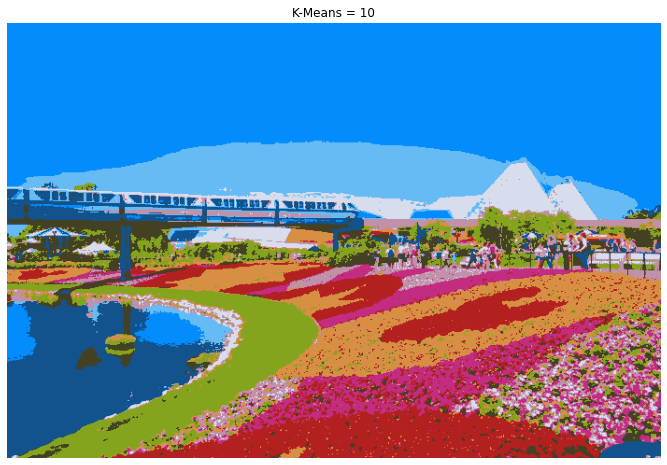

Wall time: 28.7 s


In [10]:
%%time
img_kmeans_10 = modify_img(img_pixels, img_w, img_h, KMeans(n_clusters=10, random_state=0))
draw_picture(img_kmeans_10, 'K-Means = 10', raw=False)

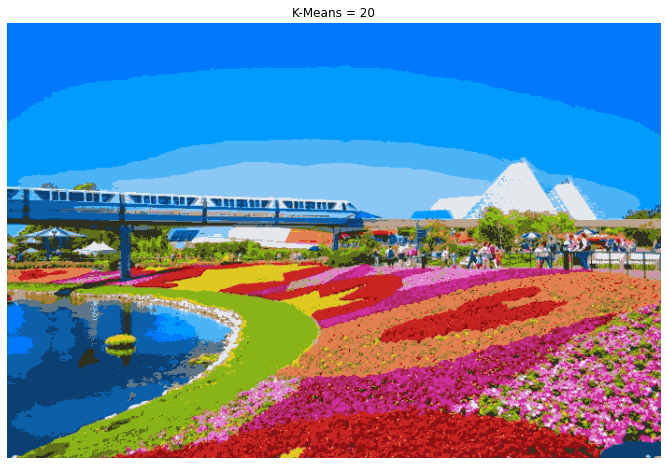

Wall time: 1min 18s


In [11]:
%%time
img_kmeans_20 = modify_img(img_pixels, img_w, img_h, KMeans(n_clusters=20, random_state=0))
draw_picture(img_kmeans_20, 'K-Means = 20', raw=False)

In [12]:
%%time
# Обучаем модель для метода DBSCAN, поскольку этот метод формирует иные атрибуты
method_DB_3 = DBSCAN(eps=3, min_samples=5)
method_DB_3.fit(img_pixels)

Wall time: 3min 17s


DBSCAN(eps=3)

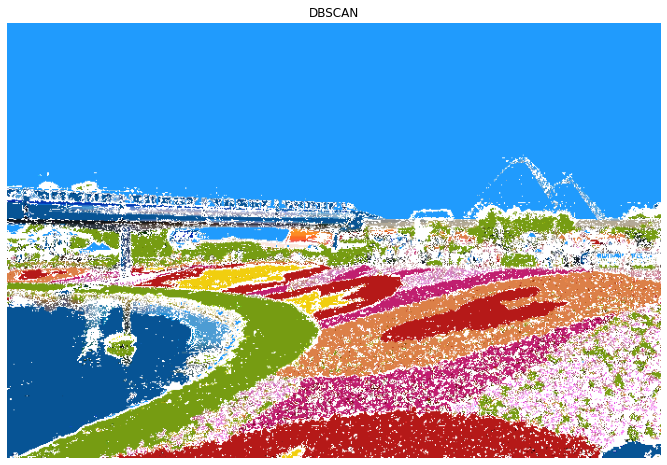

Wall time: 39.8 s


In [21]:
%%time
labels_DB_3 = set(method_DB_3.labels_)

clustered_pixels_df = pixels_df.copy()
clustered_pixels_df['cluster'] = pd.Series(method_DB_3.labels_)
clusters_channels = {}
for cluster_num in labels_DB_3:
    if cluster_num == -1:
        clusters_channels[-1] = [255, 255, 255]
    else:
        cl_r = int(clustered_pixels_df[(clustered_pixels_df.cluster == cluster_num)]['red'].mean())
        cl_g = int(clustered_pixels_df[(clustered_pixels_df.cluster == cluster_num)]['green'].mean())
        cl_b = int(clustered_pixels_df[(clustered_pixels_df.cluster == cluster_num)]['blue'].mean())
        clusters_channels[cluster_num] = [cl_r, cl_g, cl_b]
    
clusters_channels    

img_dbscan_pixels = [clusters_channels[cluster] for cluster in method_DB_3.labels_]
img_dbscan = np.array(img_dbscan_pixels).reshape(img_w, img_h, 3)
draw_picture(img_dbscan, 'DBSCAN', raw=False)


In [ ]:
img = cv2.resize(img, (128, 128))

In [11]:
%%time
# Обучаем модель для метода AgglomerativeClustering
method_AgglClstr_r_2 = AgglomerativeClustering(n_clusters=2)
method_AgglClstr_r_2.fit(img_pixels_r)

Wall time: 3min 56s


AgglomerativeClustering()

In [15]:
def draw_agglomerative(model, title):
    labels_agg = set(model.labels_)
    #print(labels_agg)
    clustered_pixels_agg = pixels_r_df.copy()
    clustered_pixels_agg['cluster'] = pd.Series(model.labels_)
    #print(clustered_pixels_agg['cluster'].value_counts())
    clusters_channels_agg = {}
    for cluster_num in labels_agg:
        cl_r = int(clustered_pixels_agg[(clustered_pixels_agg.cluster == cluster_num)]['red'].mean())
        cl_g = int(clustered_pixels_agg[(clustered_pixels_agg.cluster == cluster_num)]['green'].mean())
        cl_b = int(clustered_pixels_agg[(clustered_pixels_agg.cluster == cluster_num)]['blue'].mean())
        clusters_channels_agg[cluster_num] = [cl_r, cl_g, cl_b]

    img_agg_pixels = [clusters_channels_agg[cluster] for cluster in model.labels_]
    img_agg = np.array(img_agg_pixels).reshape(img_w_r, img_h_r, 3)
    draw_picture(img_agg, title, raw=False)

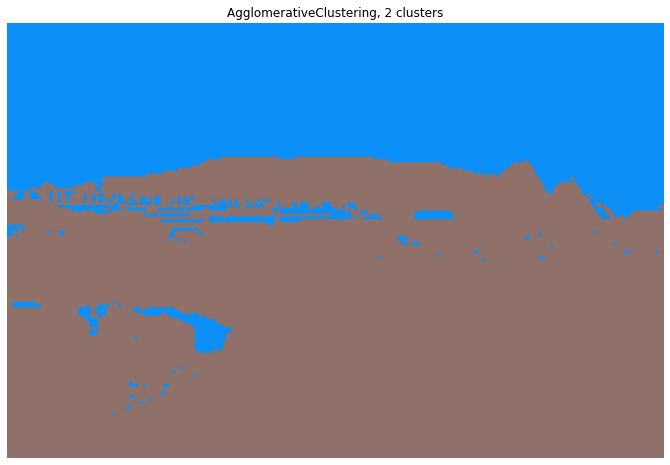

Wall time: 421 ms


In [16]:
%%time
draw_agglomerative(method_AgglClstr_r_2, 'AgglomerativeClustering, 2 clusters')

In [17]:
%%time
# Обучаем модель для метода AgglomerativeClustering
method_AgglClstr_r_5 = AgglomerativeClustering(n_clusters=5)
method_AgglClstr_r_5.fit(img_pixels_r)

Wall time: 3min 31s


AgglomerativeClustering(n_clusters=5)

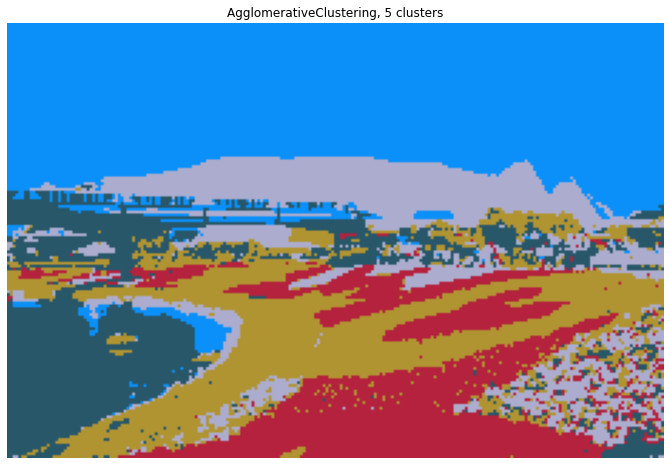

Wall time: 1.03 s


In [18]:
%%time
draw_agglomerative(method_AgglClstr_r_5, 'AgglomerativeClustering, 5 clusters')

In [19]:
%%time
# Обучаем модель для метода AgglomerativeClustering
method_AgglClstr_r_10 = AgglomerativeClustering(n_clusters=10)
method_AgglClstr_r_10.fit(img_pixels_r)

Wall time: 2min 36s


AgglomerativeClustering(n_clusters=10)

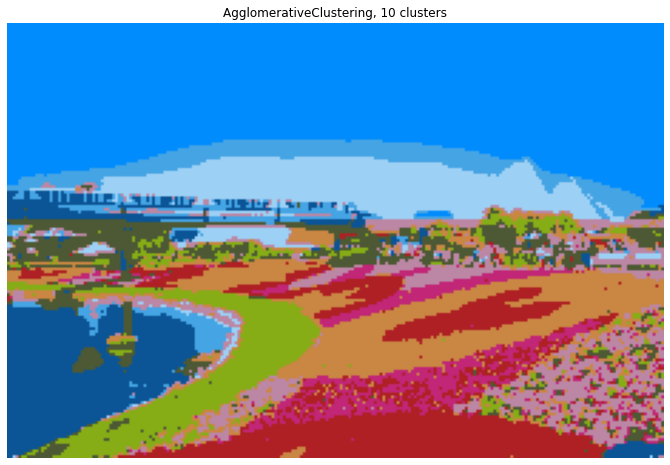

Wall time: 2.27 s


In [21]:
%%time
draw_agglomerative(method_AgglClstr_r_10, 'AgglomerativeClustering, 10 clusters')

In [20]:
%%time
# Обучаем модель для метода AgglomerativeClustering
method_AgglClstr_r_20 = AgglomerativeClustering(n_clusters=20)
method_AgglClstr_r_20.fit(img_pixels_r)

Wall time: 2min 13s


AgglomerativeClustering(n_clusters=20)

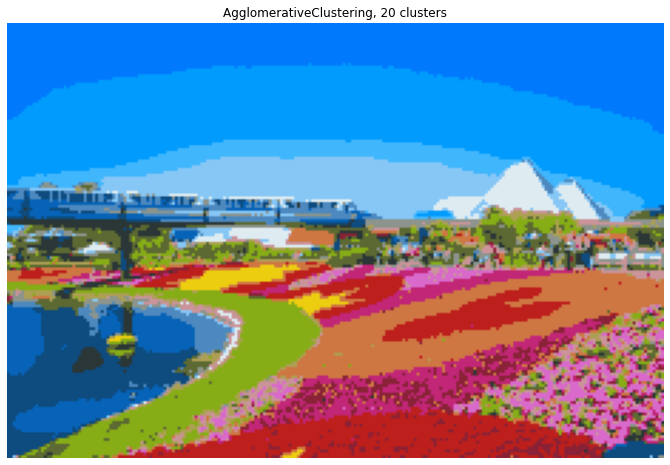

Wall time: 546 ms


In [22]:
%%time
draw_agglomerative(method_AgglClstr_r_20, 'AgglomerativeClustering, 20 clusters')

In [29]:
%%time
# Обучаем модель для метода AgglomerativeClustering
method_AgglClstr_2 = AgglomerativeClustering(n_clusters=2, linkage='single')
method_AgglClstr_2.fit(img_pixels)

Wall time: 30min 1s


AgglomerativeClustering(linkage='single')

{0, 1}
0    326199
1         1
Name: cluster, dtype: int64


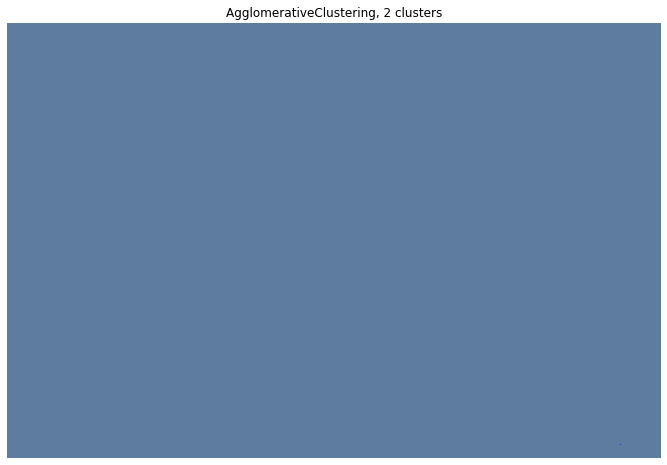

Wall time: 1.26 s


In [41]:
%%time

labels_agg = set(method_AgglClstr_2.labels_)
print(labels_agg)
clustered_pixels_agg2 = pixels_df.copy()
clustered_pixels_agg2['cluster'] = pd.Series(method_AgglClstr_2.labels_)
print(clustered_pixels_agg2['cluster'].value_counts())
clusters_channels_agg2 = {}
for cluster_num in labels_agg:
    cl_r = int(clustered_pixels_agg2[(clustered_pixels_agg2.cluster == cluster_num)]['red'].mean())
    cl_g = int(clustered_pixels_agg2[(clustered_pixels_agg2.cluster == cluster_num)]['green'].mean())
    cl_b = int(clustered_pixels_agg2[(clustered_pixels_agg2.cluster == cluster_num)]['blue'].mean())
    clusters_channels_agg2[cluster_num] = [cl_r, cl_g, cl_b]
    
clusters_channels_agg2    

img_agg2_pixels = [clusters_channels_agg2[cluster] for cluster in method_AgglClstr_2.labels_]
img_agg2 = np.array(img_agg2_pixels).reshape(img_w, img_h, 3)
draw_picture(img_agg2, 'AgglomerativeClustering, 2 clusters', raw=False)


In [42]:
%%time
# Обучаем модель для метода AgglomerativeClustering
method_AgglClstr_5 = AgglomerativeClustering(n_clusters=5, linkage='single', affinity='manhattan')
method_AgglClstr_5.fit(img_pixels)

Wall time: 19min 59s


AgglomerativeClustering(affinity='manhattan', linkage='single', n_clusters=5)

{0, 1, 2, 3, 4}
0    326191
2         6
1         1
3         1
4         1
Name: cluster, dtype: int64


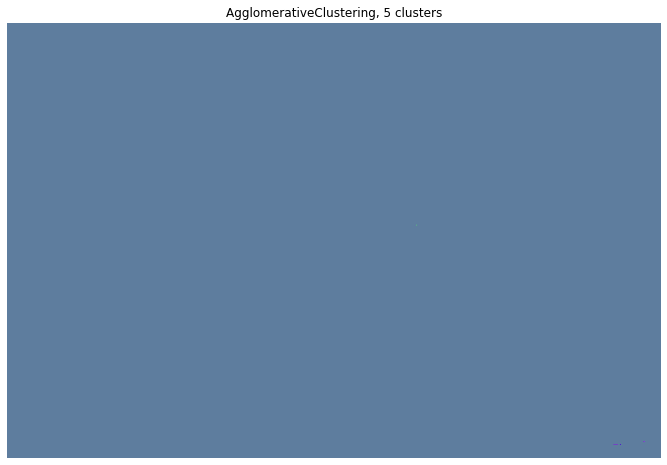

Wall time: 1.12 s


In [43]:
%%time
labels_agg5 = set(method_AgglClstr_5.labels_)
print(labels_agg5)
clustered_pixels_agg5 = pixels_df.copy()
clustered_pixels_agg5['cluster'] = pd.Series(method_AgglClstr_5.labels_)
print(clustered_pixels_agg5['cluster'].value_counts())
clusters_channels_agg5 = {}
for cluster_num in labels_agg5:
    cl_r = int(clustered_pixels_agg5[(clustered_pixels_agg5.cluster == cluster_num)]['red'].mean())
    cl_g = int(clustered_pixels_agg5[(clustered_pixels_agg5.cluster == cluster_num)]['green'].mean())
    cl_b = int(clustered_pixels_agg5[(clustered_pixels_agg5.cluster == cluster_num)]['blue'].mean())
    clusters_channels_agg5[cluster_num] = [cl_r, cl_g, cl_b]
    
clusters_channels_agg5    

img_agg5_pixels = [clusters_channels_agg5[cluster] for cluster in method_AgglClstr_5.labels_]
img_agg5 = np.array(img_agg5_pixels).reshape(img_w, img_h, 3)
draw_picture(img_agg5, 'AgglomerativeClustering, 5 clusters', raw=False)

### 3. Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.


In [48]:
from skimage.metrics import structural_similarity
def get_ssim(before, after):
    # Считаем SSIM
    (score, diff) = structural_similarity(before, after, full=True, multichannel=True)
    return score

import warnings
warnings.filterwarnings('ignore')

In [50]:
print(f'KMeans, 2 кластера {get_ssim(img_matrix, img_kmeans_2)}')
print(f'KMeans, 5 кластеров {get_ssim(img_matrix, img_kmeans_5)}')
print(f'KMeans, 10 кластеров {get_ssim(img_matrix, img_kmeans_10)}')
print(f'KMeans, 20 кластеров {get_ssim(img_matrix, img_kmeans_20)}')
print(f'DBSCAN {get_ssim(img_matrix, img_dbscan)}')
print(f'AgglomerativeClustering, 2 кластера {get_ssim(img_matrix, img_agg2)}')
print(f'AgglomerativeClustering, 5 кластеров {get_ssim(img_matrix, img_agg5)}')

KMeans, 2 кластера 0.36377539232009876
KMeans, 5 кластеров 0.5103030099528497
KMeans, 10 кластеров 0.6800865146350522
KMeans, 20 кластеров 0.7775529372206829
DBSCAN 0.3944735408114797
AgglomerativeClustering, 2 кластера 0.33337252646478904
AgglomerativeClustering, 5 кластеров 0.3333721302997168


### 4. Сформулируйте выводы по проделанной работе.  
a) Какая модель показала лучший результат?

Лучший результат с точки зрения качества получившегося изображения - KMeans с 20 кластерами.
При этом и по скорости работы, и по удобству обработки метод KMeans представляется самым удобным для этой работы. 
Самым долгим по времени работы и самым неубедительным по результатам оказался метод AgglomerativeClustering. При попытке запустить этот метод с параметрами по умолчанию он вообще не запустился, было выведено сообщение о невозможности выделить несколько терабайт памяти. Предпринятые "игры" с параметрами позволили алгоритм запустить, но фактически все точки попали в один из кластеров, а в другие кластеры попало несколько точек, которые на финальном изображении даже не видны.

Также неоднозначным оказалось использование алогритма DBSCAN. Он отсек значительное количество точек, которые не вошли ни в один из кластеров, и при этом общее количество кластеров превысило 2000.
Все точки, которые оказались за пределами кластера, я показал как белые точки - просто чтобы было видно, как они распределились на изображении. Если бы эти точки сохранили свои оригинальные цвета, качество работы этого алгоритма могло бы быть лучше.